Installation:
    
Run in python console :
import nltk; nltk.download('stopwords')

Run in terminal or command prompt :
python3 -m spacy download en

Imports

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

c:\users\draka\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Prepare stopwords

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

Import Newsgroups datas

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


Remove emails and newline characters

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


Tokenize words and Clean-up text

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


Creating Bigram and Trigram Models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

c:\users\draka\appdata\local\programs\python\python36\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


Remove Stopwords, Make Bigrams and Lemmatize

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in text[:20]] for text in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1)]]

Building the Topic Model

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

View the topics in LDA model

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.012*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

Compute Model Perplexity and Coherence Score

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754125204970952

Coherence Score:  0.515758393754623


Visualize the topics-keywords

In [14]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\users\draka\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.336970 -0.001279       1        1  16.257160
13     0.291069 -0.003109       2        1  15.227403
18     0.328796 -0.128184       3        1  14.572030
2      0.091773  0.226449       4        1   6.162448
15     0.059667  0.222611       5        1   5.973670
10    -0.084991 -0.112871       6        1   4.344125
17     0.060975 -0.182988       7        1   4.177870
12    -0.022521 -0.036456       8        1   3.586154
5     -0.022910 -0.021269       9        1   3.365451
16    -0.029283  0.219740      10        1   3.271720
6     -0.062705 -0.017219      11        1   3.227774
9     -0.062843  0.139473      12        1   2.969708
14    -0.088859 -0.062625      13        1   2.741288
3     -0.047751 -0.117466      14        1   2.731815
8     -0.111493  0.003700      15        1   2.290859
19    -0.113678 -0.023377      16        1   2.124086
11    -0.092188 -0.110819      17        1   2.081734
4     -0.134207  0.001647      18        1   1.693799
0     -0.164202 -0.027974      19        1   1.679179
1     -0.131620  0.032014      20        1   1.521724, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4146   Default  57084.000000            ax  57084.000000  30.0000  30.0000
21     Default  12491.000000          line  12491.000000  29.0000  29.0000
82     Default  16294.000000           not  16294.000000  28.0000  28.0000
30     Default  11141.000000  organization  11141.000000  27.0000  27.0000
3721   Default   3845.000000           max   3845.000000  26.0000  26.0000
65     Default  10454.000000            do  10454.000000  25.0000  25.0000
322    Default   9655.000000         write   9655.000000  24.0000  24.0000
55     Default   7586.000000       article   7586.000000  23.0000  23.0000
244    Default   8048.000000            be   8048.000000  22.0000  22.0000
154    Default  11783.000000         would  11783.000000  21.0000  21.0000
303    Default   6906.000000           say   6906.000000  20.0000  20.0000
226    Default   5804.000000            go   5804.000000  19.0000  19.0000
29     Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000          host   4083.000000  17.0000  17.0000
118    Default   6852.000000           get   6852.000000  16.0000  16.0000
46     Default   5027.000000    university   5027.000000  15.0000  15.0000
1911   Default   1863.000000         space   1863.000000  14.0000  14.0000
215    Default   2294.000000        window   2294.000000  13.0000  13.0000
36     Default   3735.000000             s   3735.000000  12.0000  12.0000
18     Default   7292.000000          know   7292.000000  11.0000  11.0000
50     Default   3461.000000          year   3461.000000  10.0000  10.0000
317    Default   4598.000000           use   4598.000000   9.0000   9.0000
2726   Default   1540.000000          game   1540.000000   8.0000   8.0000
23     Default   1948.000000          mail   1948.000000   7.0000   7.0000
681    Default   3006.000000         right   3006.000000   6.0000   6.0000
967    Default   1684.000000     christian   1684.000000   5.0000   5.0000
1362   Default   1746.000000    government   1746.000000   4.0000   4.0000
567    Default   1464.000000          team   1464.000000   3.0000   3.0000
206    Default   3380.000000        system   3380.000000   2.0000   2.0000
60     Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11736  Topic20    119.370972          guru    120.322853   4.1774  -5.3259
3548   Topic20    117.623474  countersteer    118.575356   4.1773  -5.3407
10436  Topic20    113.026138       bradley    113.978020   4.1769  -5.3805
280    Topic20    112.216789          lane    113.168671   4.1769  -5

Building LDA Mallet Model

In [30]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})
mallet_path = 'C:\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [31]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('post', 0.020505582997800007),
   ('information', 0.017530751456283813),
   ('mail', 0.014957176262227942),
   ('list', 0.013836425774493932),
   ('send', 0.013518187981680573),
   ('group', 0.013172277337318223),
   ('file', 0.011719452630996361),
   ('address', 0.011345869135085025),
   ('internet', 0.010474174311291906),
   ('include', 0.009035186030744538)]),
 (8,
  [('key', 0.03156848919941029),
   ('system', 0.013813217101467854),
   ('encryption', 0.01139350041663996),
   ('chip', 0.010592269726299596),
   ('security', 0.00934234984936863),
   ('bit', 0.009262226780334594),
   ('technology', 0.00923017755272098),
   ('government', 0.008412922248573809),
   ('public', 0.007483494647778989),
   ('standard', 0.00660214088840459)]),
 (4,
  [('question', 0.01365974603763092),
   ('make', 0.011724904995829085),
   ('exist', 0.010751691537677265),
   ('people', 0.010380943553619426),
   ('write', 0.010253498934099546),
   ('reason', 0.0101839836870887),
   ('claim', 0.0100449

How to find the optimal number of topics for LDA?

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [46]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

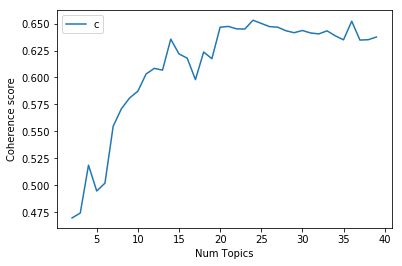

In [47]:
# Show graph
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4698
Num Topics = 3  has Coherence Value of 0.4743
Num Topics = 4  has Coherence Value of 0.5187
Num Topics = 5  has Coherence Value of 0.4947
Num Topics = 6  has Coherence Value of 0.502
Num Topics = 7  has Coherence Value of 0.5548
Num Topics = 8  has Coherence Value of 0.571
Num Topics = 9  has Coherence Value of 0.581
Num Topics = 10  has Coherence Value of 0.5873
Num Topics = 11  has Coherence Value of 0.6032
Num Topics = 12  has Coherence Value of 0.6085
Num Topics = 13  has Coherence Value of 0.6068
Num Topics = 14  has Coherence Value of 0.6356
Num Topics = 15  has Coherence Value of 0.6219
Num Topics = 16  has Coherence Value of 0.6179
Num Topics = 17  has Coherence Value of 0.598
Num Topics = 18  has Coherence Value of 0.6236
Num Topics = 19  has Coherence Value of 0.6174
Num Topics = 20  has Coherence Value of 0.6466
Num Topics = 21  has Coherence Value of 0.6473
Num Topics = 22  has Coherence Value of 0.6451
Num Topics = 23  has Cohe

In [49]:
# Select the model and print the topics
optimal_model = model_list[np.argmax(coherence_values)]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(1,
  '0.038*"key" + 0.033*"_" + 0.014*"encryption" + 0.010*"chip" + '
  '0.008*"security" + 0.008*"system" + 0.008*"bit" + 0.008*"clipper" + '
  '0.008*"technology" + 0.007*"clipper_chip" + 0.007*"algorithm" + '
  '0.006*"secure" + 0.006*"government" + 0.006*"phone" + 0.006*"public" + '
  '0.005*"encrypt" + 0.005*"secret" + 0.005*"crypto" + 0.005*"law_enforcement" '
  '+ 0.004*"message"'),
 (16,
  '0.017*"people" + 0.015*"day" + 0.014*"time" + 0.013*"leave" + 0.012*"start" '
  '+ 0.010*"back" + 0.010*"happen" + 0.008*"home" + 0.008*"face" + '
  '0.008*"hear" + 0.008*"call" + 0.007*"hand" + 0.007*"live" + 0.007*"head" + '
  '0.006*"woman" + 0.006*"turn" + 0.006*"kill" + 0.006*"thing" + 0.006*"put" + '
  '0.006*"stand"'),
 (12,
  '0.028*"drive" + 0.022*"card" + 0.018*"system" + 0.015*"scsi" + '
  '0.014*"driver" + 0.014*"problem" + 0.013*"mac" + 0.012*"bit" + '
  '0.011*"monitor" + 0.010*"work" + 0.010*"apple" + 0.009*"memory" + '
  '0.009*"board" + 0.009*"machine" + 0.009*"disk" + 0.0

Finding the dominant topic in each sentence

In [39]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.1895,"car, good, buy, engine, speed, drive, article,...",From: (wheres my thing) Subject: WHAT car is t...
1,1,1.0,0.1658,"card, driver, mac, bit, monitor, apple, proble...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,19.0,0.2600,"bike, write, line, article, organization, dod,...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,5.0,0.3047,"window, application, run, server, display, mot...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,21.0,0.1287,"drive, scsi, system, disk, problem, work, datu...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,24.0,0.4418,"car, good, buy, engine, speed, drive, article,...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,17.0,0.1690,"organization, line, university, host, nntp_pos...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,11.0,0.1588,"line, organization, university, sale, sell, pr...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,27.0,0.1208,"gun, law, state, people, crime, weapon, firear...",Subject: Re: Dont more innocents die without t...
9,9,13.0,0.2462,"people, exist, question, argument, evidence, g...",From: (Jon Livesey) Subject: Re: Genocide is C...


Find the most representative document for each topic

In [44]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

for i in range(len(sent_topics_sorteddf_mallet)):
    print(i, sent_topics_sorteddf_mallet.loc[i, 'Text'])

0 From: Subject: ALL-TIME PEAK PLAYERS Organization: Ball State University, Muncie, In - Univ. Computing Svcs Lines: 195 Last week I posted the ALL-TIME GREATEST PLAYERS (and haphazardly misspelled several names--SORRY!) This week, its time for the greatest PEAK players. I evaluated the following players on 4 consectutive seasons which constituted their "prime" or "peak" years. (3 was too few; 5 seemed to many--so I settled for 4). Sources, as usual, include Total Baseball 1993 and my own (biased) opinions. Here goes, feel free to comment. 1. Ted Williams (includes season after war)--missed actual peak years 2. Babe Ruth 3. Walter Johnson 4. Mickey Mantle 5. Mike Schmidt (actual peak year shortened by strike) 6. Barrry Bonds (currently at peak) 7. Honus Wagner 8. Ty Cobb 9. Tris Speaker 10. Willie Mays 11. Lefty Grove 12. Sandy Koufax 13. Joe Morgan 14. Ed Walsh 15. Christy Mathewson 16. Lou Gehrig 17. Jimmie Foxx 18. Cal Ripken Jr. 19. Pete Alexander 20. Cy Young 21. Tim Raines 22. Ri

2 From: Center for Policy Research Subject: From Israeli press. Madness. Nf-ID: #N:cdp:1483500342:000:6673 Nf-From: cdp.UUCP!cpr Apr 16 16:49:00 1993 Lines: 130 From: Center for Policy Research <cpr> Subject: From Israeli press. Madness. /* Written 4:34 pm Apr 16, 1993 by in igc:mideast.forum */ /* ---------- "From Israeli press. Madness." ---------- */ FROM THE ISRAELI PRESS. Paper: Zman Tel Aviv (Tel Avivs time). Friday local Tel Avivs paper, affiliated with Maariv. Date: 19 February 1993 Journalist: Guy Ehrlich Subject: Interview with soldiers who served in the Duvdevan (Cherry) units, which disguise themselves as Arabs and operate within the occupied territories. Excerpts from the article: "A lot has been written about the units who disguise themselves as Arabs, things good and bad, some of the falsehoods. But the most important problem of those units has been hardly dealt with. It is that everyone who serves in the Cherry, after a time goes in one way or another insane". A man who

3 From: (Clinton/Gore 92) Subject: CLINTON: Background BRiefing in Vancouver 4.4.93 Organization: Project GNU, Free Software Foundation, 675 Mass. Ave., Cambridge, MA 02139, USA +1 (617) 876-3296 Lines: 993 NNTP-Posting-Host: life.ai.mit.edu THE WHITE HOUSE Office of the Press Secretary (Vancouver, British Columbia) ______________________________________________________________ BACKGROUND BRIEFING BY SENIOR ADMINISTRATION OFFICIALS April 4, 1993 Canada Place Vancouver, British Columbia 9:40 A.M. PST Folks, were about to start the BACKGROUND BRIEFING on the aid package. SENIOR ADMINISTRATION OFFICIAL: Good morning. The President -- President Clinton and President Yeltsin agreed yesterday on a series of American initiatives to support economic and political reform in Russia, and its valued at $1.6 billion. Before taking your questions and running through the basic outlines of this package, I want to make a few points. First, this is the maximum that the Clinton administration can do with

4 From: (Scott W Roby) Subject: Re: BATF/FBI Murders Almost Everyone in Waco Today! 4/19 Nntp-Posting-Host: chopin.udel.edu Organization: University of Delaware Lines: 97 In article (Jim De Arras) writes: >In article (Scott W Roby) >writes: >> In article (Jim De >Arras) writes: >> >In article (Scott W Roby) >> >writes: >> >> I agree that they deserved a trial. They had more than 40 days to come >> >> out and get their trial. They chose to keep the children with them and >> >> to stay inside. They chose to stay inside even after they were tear >gassed. >> >> I do not find these actions rational. Even Noriega was smart enough to >> >> give up and go for the trial he deserved. >> >> >> > >> >Mr. Roby, you are a government sucking heartless bastard. >> >> Unworthy of comment. > >But apparently true. My opinion, only, of course. So, your opinion is truth. I see... :-) >> >Humans died >> >yesterday, humans who would not have died if the FBI had not taken the >> >actions >> >they did. That is

5 From: (David B. Lewis) Subject: comp.windows.x Frequently Asked Questions (FAQ) 5/5 Summary: useful information about the X Window System Article-I.D.: visual.C52Eqq.99A Expires: Sun, 2 May 1993 00:00:00 GMT Reply-To: (X FAQ maintenance address) Organization: VISUAL, Inc. Lines: 890 Archive-name: x-faq/part5 Last-modified: 1993/04/04 ---------------------------------------------------------------------- Subject: 119) Im writing a widget and cant use a float as a resource value. Float resources are not portable; the size of the value may be larger than the size of an XtPointer. Try using a pointer to a float instead; the Xaw Scrollbar float resources are handled in this way. ---------------------------------------------------------------------- Subject: 120) Is this a memory leak in the X11R4 XtDestroyWidget()?! Yes. This is the "unofficial" fix-19 for the X11R4 Destroy.c: *** Destroy.c.1.37 Thu Jul 11 15:41:25 1991 --- lib/Xt/Destroy.c Thu Jul 11 15:42:23 1991 *************** *** 1,4

6 From: (Clipper Chip Announcement) Subject: text of White House announcement and Q&As on clipper chip encryption Organization: National Institute of Standards & Technology Distribution: na Lines: 282 Note: This file will also be available via anonymous file transfer from csrc.ncsl.nist.gov in directory /pub/nistnews and via the NIST Computer Security BBS at 301-948-5717. --------------------------------------------------- THE WHITE HOUSE Office of the Press Secretary _________________________________________________________________ For Immediate Release April 16, 1993 STATEMENT BY THE PRESS SECRETARY The President today announced a new initiative that will bring the Federal Government together with industry in a voluntary program to improve the security and privacy of telephone communications while meeting the legitimate needs of law enforcement. The initiative will involve the creation of new products to accelerate the development and use of advanced and secure telecommunications net


7 From: Center for Policy Research Subject: Poem by Erich Fried Nf-ID: #N:cdp:1483500363:000:1387 Nf-From: cdp.UUCP!cpr Apr 25 05:29:00 1993 Lines: 46 From: Center for Policy Research <cpr> Subject: Poem by Erich Fried Poem by German-Jewish poet Erich Fried (Holocaust survivor) Ein Jude an die zionistischen Kaempfer - 1988 von Erich Fried Was wollt ihr eigentlich ? Wollt ihr wirklich die uebertreffen die euch niedergetreten haben vor einem Menschenalter in euer eigenes Blut und in euren eigenen Kot ? * Wollt ihr die alten Foltern jetzt an andere weitergeben mit allen blutigen dreckigen Einzelheiten mit allem brutalen Genuss die Folterknechte wie unsere Vaeter sie damals erlitten haben ? * Wollt jetzt wirklich ihr die neue Gestapo sein die neue Wehrmacht die neue SA and SS und aus den Palaestinensern die neuen Juden machen ? * Aber dann will auch ich weil ich damals vor fuenfzig Jahren selbst als ein Judenkind gepeinigt wurde von euren Peinigern ein neuer Jude sein mit diesen neuen Jud

8 From: (Landon C. Noll) Subject: Reposting: 10th International Obfuscated C Code Contest rules (2 of 2) Expires: 8 May 93 00:00:00 GMT Reply-To: (Landon C. Noll) Distribution: world Organization: Nebula Consultants in San Francisco Lines: 1409 Keywords: ioccc We have received a number of requests for a reposting of the International Obfuscated C Code Contest rules and guidelines. Also some people requested that these rules be posted to a wider set of groups. Sorry for the cross posting. Some technical clarifications were made to the rules and guidelines. (See the diff marks at the right hand edge) The rules and guidelines for this year remain the same, so people who have already or are in the process of submitting entries for the 1993 IOCCC need not worry about these changes. chongo <Landon Curt Noll> /\cc/\ Larry Bassel =-= #!/bin/sh # This is part 02 of a multipart archive # ============= mkentry.c ============== echo "x - extracting mkentry.c (Text)" sed s/^X// << SHAR_EOF > mkentr

9 From: Center for Policy Research Subject: Final Solution for Gaza ? Nf-ID: #N:cdp:1483500354:000:5791 Nf-From: cdp.UUCP!cpr Apr 23 15:10:00 1993 Lines: 126 From: Center for Policy Research <cpr> Subject: Final Solution for Gaza ? Final Solution for the Gaza ghetto ? ------------------------------------ While Israeli Jews fete the uprising of the Warsaw ghetto, they repress by violent means the uprising of the Gaza ghetto and attempt to starve the Gazans. The Gaza strip, this tiny area of land with the highest population density in the world, has been cut off from the world for weeks. The Israeli occupier has decided to punish the whole population of Gaza, some 700.000 people, by denying them the right to leave the strip and seek work in Israel. While Polish non-Jews risked their lives to save Jews from the Ghetto, no Israeli Jew is known to have risked his life to help the Gazan resistance. The only help given to Gazans by Israeli Jews, only dozens of people, is humanitarian assistan

10 From: Subject: Grounding power wiring, was Re: a question about 120VAC outlet wiring Lines: 163 Nntp-Posting-Host: auvax1 Organization: Adelphi University, Garden City NY There has been quite a bit of discussion about house wiring and grounding practices here. A few points need to be clarified: The Equipment GROUNDING conductor, Green, green with a yellow stripe, bare, or the metal sheath or pipe of SOME wiring methods, is used as a safety ground, to carry fault currents back to the circuit breaker panel, and to limit the voltage on the metal case of utilization equipment or other metal objects. It should never (except for a few exceptions to be discussed later) carry the normal operating current of a connected load. Some equipment has filters in the power supply which may cause some slight current flow through the grounding conductor. Much communications or audio equipment is sensitive to noise or slight voltages on the grounding conductor, and may require special wiring of the gro

11 From: (Bob Douglas) Subject: Re: Sphere from 4 points? Organization: Oxford University Computing Service, 13 Banbury Rd, Oxford, U Lines: 94 Originator: In article (Steven Collins) writes: >In article (Edward Bolson) writes: >>Boy, this will be embarassing if it is trivial or an FAQ: >> >>Given 4 points (non coplanar), how does one find the sphere, that is, >>center and radius, exactly fitting those points? I know how to do it >>for a circle (from 3 points), but do not immediately see a >>straightforward way to do it in 3-D. I have checked some >>geometry books, Graphics Gems, and Farin, but am still at a loss? >>Please have mercy on me and provide the solution? > >Wouldnt this require a hyper-sphere. In 3-space, 4 points over specifies >a sphere as far as I can see. Unless that is you can prove that a point >exists in 3-space that is equi-distant from the 4 points, and this may not >necessarily happen. > >Correct me if Im wrong (which I quite possibly am!) > >steve Sorry!! :-) Call

12 From: (Paul Harvey) Subject: Re: Sabbath Admissions 5of5 Organization: The Duck Pond public unix: +1 408 249 9630, log in as guest. Lines: 155 I wrote in response to (Darius_Lecointe): >[Its not clear how much more needs to be said other than the FAQ. I >think Pauls comments on esteeming one day over another (Rom 14) is >probably all that needs to be said. Was Paul a God too? Is an interpretation of the words of Paul of higher priority than the direct word of Jesus in Matt5:14-19? Paul begins Romans 14 with "If someone is weak in the faith ..." Do you count yourself as one who is weak in the faith? >I accept that Darius is doing >what he does in honor of the Lord. I just wish he might equally >accept that those who "esteem all days alike" are similarly doing >their best to honor the Lord. Yes, but what does the Bible have to say? What did Jesus say? Paul closes Romans 14 with, "On the other hand, the person with doubts about something who eats it anyway is guilty, because he isnt ac

13 From: (Robert Singleton) Subject: Re: Americans and Evolution Organization: Massachvsetts Institvte of Technology Lines: 138 Distribution: world NNTP-Posting-Host: thnext.mit.edu In article (Benedikt Rosenau) writes: > In article > (Robert Singleton) writes: > > (Deletion) > > > >I will argue that your latter statement, "I believe that no gods exist" > >does rest upon faith - that is, if you are making a POSITIVE statement > >that "no gods exist" (strong atheism) rather than merely saying I dont > >know and therefore dont believe in them and dont NOT believe in then > >(weak atheism). Once again, to not believe in God is different than > >saying I BELIEVE that God does not exist. I still maintain the > >position, even after reading the FAQs, that strong atheism requires > >faith. > > > > No it in the way it is usually used. In my view, you are saying here > that driving a car requires faith that the car drives. > Im not saying this at all - it requires no faith on my part to say the

14 From: (L. Detweiler) Subject: Privacy & Anonymity on the Internet FAQ (1 of 3) Supersedes: Organization: TMP Enterprises Lines: 1220 Expires: 21 May 1993 04:00:06 GMT Reply-To: NNTP-Posting-Host: pad-thai.aktis.com Summary: Email and account privacy, anonymous mailing and posting, encryption, and other privacy and rights issues associated with use of the Internet and global networks in general. X-Last-Updated: 1993/03/04 Archive-name: net-privacy/part1 Last-modified: 1993/3/3 Version: 2.1 IDENTITY, PRIVACY, and ANONYMITY on the INTERNET ================================================ (c) 1993 L. Detweiler. Not for commercial use except by permission from author, otherwise may be freely copied. Not to be altered. Please credit if quoted. SUMMARY ======= Information on email and account privacy, anonymous mailing and posting, encryption, and other privacy and rights issues associated with use of the Internet and global networks in general. (Search for <#.#> for exact section. Search 

15 From: (Eric Marsh) Subject: Re: After 2000 years, can we say that Christian Morality is Organization: Sun Lines: 82 NNTP-Posting-Host: hernes-sun In article (Frank ODwyer) writes: >In article (Eric Marsh) writes: >#In article (Frank ODwyer) writes: >#>Science ("the real world") has its basis in values, not the other way round, >#>as you would wish it. If there is no such thing as objective value, then >#>science can not objectively be said to be more useful than a kick in the head. >#>Simple theories with accurate predictions could not objectively be said >#>to be more useful than a set of tarot cards. You like those conclusions? >#>I dont. >#I think that you are changing the meaning of "values" here. Perhaps >#it is time to backtrack and take a look at the word. >#value n. 1. A fair equivalent or return for something, such as goods >#or service. 2. Monetary or material worth. 3. Worth as measured in >#usefulness or importance; merit. 4. A principle, standard, or quality >#considere

16 Subject: roman 02/14 From: (Cliff) Reply-To: (Cliff) Distribution: usa Organization: University of South Dakota Keywords: bmp, wallpaper Lines: 958 ------------ Part 2 of 14 ------------ M0./CXT!)27M)X^-)X^/CBN/C24E[X^.*X^/CX^.*X^,RBN.*,HKC,GOC,N-[ MY_/SYS*/CT[S\X_S3N>/C^>/CX_S\UA.Y_/SC_./C_-8C_./C_/GCX^/Y_./ M\X_SCX^/\_./C_/S\_./\X^/\X^/CX_SCX^/C_./CX^/\X^/C_./CX^/CX^/ M\X^OC_./\X^/C_./CX_SCX_S\X^/\_./CX^/\X_SCX_SCX^/CX^/CX^/C_./ MCX^/CX_SCX^/C_./CX\ORI&1RI$Z0<K*D2\O.MC8.CK*.D$ZRCK*V#I!V,IM M;<K*.CK*;3HZ0=C8V&UMV,K*RCHZ.MC8;7/*RG-!RCK8.LIS.FW8V#K*;3I! M.LHZ.CHO+T$Z.CK*+SIMRCK8+T*.CI!V,K*V#HOD9&1.CHO+SHZ08;*.CHZ M:9$ZAI$Z+SHZAD$ORI$Z.B\ZQR^&:6EIACKD9&1+SHZQY&&D9&1:2^1:2_ MAL<OQR_D<>1QX;D89IQ\>1D;^&:<?QY&&QY$U:6GQVF1:<=I:89IAK_ MQ\?Q\?QY&1O[^&QX:1AIQR^&+X;:2\O:<=IQVGAFGD8:1D<=I.B^1 M:9%I+X8Z:6E!+X8ZRI$Z.LHOAH8Z.CHO+Y&1098.CHZ.CK*+\K8V,K*<\K8 M<]C*<VW803IS<Y9S<\K*;<IS/-C*/)9S<]AS/#QMV#R6V-AS;99S<Y:6/#P\ M/$4\ECQ%/-ST3P\/#Q%<SS1T3P\<]1ED66W=1/#S=T471W=W1/#Q%/-W= M13Q%W=U%13P\T45%/-=W=W

17 From: (Robert Rubinoff) Subject: Re: Gritz/JBS/Liberty Lobby/LaRouche/Christic Insitute/Libertarian/... Nntp-Posting-Host: spino.soar.cs.cmu.edu Organization: School of Computer Science, Carnegie Mellon Lines: 15 In article writes: >Note that Bo Gritz was on the Populist party ticket with David >Duke (for veep) in 1988 until he found out that Duke was leading >he ticket, when he withdrew his candidacy. So Gritz gave up his >chance to be Vice President of the US just to aviod supporting >Duke. Id hardly call that "giving up his chance to be Vice President of the US"; the chance of the Populist Party ticket winning is essentially nil. Still, it does imply that he doesnt want to be associated with Duke. Robert 


18 From: (Serdar Argic) Subject: SDPA has made "Armenian" synonymous with "idiot" or "criminal/Nazi". Reply-To: (Serdar Argic) Distribution: world Lines: 208 In article writes: >In your (and Mutlu/Argic/Cosars and thousands of others like you) SDPA.ORG criminals/Nazis in action. Your fascist government got away with the genocide of 2.5 million Turkish men, women and children and is enjoying the fruits of that genocide. And your criminal organization will not get away with the genocides cover-up. In June 1915, a major uprising took place in Sebinkarahisar under the leadership of the famous Nazi Boyadjian. The Moslem districts were burnt down. Hundreds of soldiers and gendarmerie were killed and hundreds of civilians also perished. Armenians first of all occupied the Talori region, which included the villages of Siner, Simai, Gulli-Guzat, Ahi, Hedenk, Sinank, Ekind, Effard, Musson, Etek, Akcesser. Leaving their wives, children and property in these inaccessible spots, the Armenians joine

19 From: (Nikos I Nassuphis) Subject: LGA ncrypt source Organization: Massachusetts Institute of Technology Lines: 1135 NNTP-Posting-Host: w20-575-104.mit.edu I got a number of requests for code. So, here it is. Its written in 80x86 ASM. Borland TASM will do. TASM LGA.ASM TLINK /t LGA.ASM The code: ;---------------------------------------------------------------------- ; LGA ncryption ; (C) by Nick Nassuphis ;---------------------------------------------------------------------- CODE SEGMENT ASSUME CS:CODE, DS:CODE ORG 100h Start: JMP Begin ;---------------------------------------------------------------------- ; ; Gas particle assigment: ; ; BIT 0 particle moving EAST ; BIT 1 particle moving WEST ; BIT 2 particle moving NORTH ; BIT 3 particle moving SOUTH ; ; BIT 4 particle moving EAST ; BIT 5 particle moving WEST ; BIT 6 particle moving NORTH ; BIT 7 particle moving SOUTH ; ; ; Collisiong Rules: ; ; 1. Gas Rules ; ; IF (E & W) AND !(N & S) THEN (E,W)->(N,S) ; IF (N & S) AND !(E & W) 

20 From: (Cindy Tittle Moore) Subject: Re: Canon BJ200 (BubbleJet) and HP DeskJet 500... Nntp-Posting-Host: alexandre-dumas.ics.uci.edu Reply-To: (Cindy Tittle Moore) Organization: ICS Dept., UC Irvine Keywords: printer Lines: 25 In (Sean Eckton) writes: >>The deskjet is SLOW. This is in comparison to the other printers I >>mentioned. I have no idea how the bubblejet compares. >> >>The interface between Win3.1 and the printer is just dandy, Ive not >>had any problems with it. >I just bought a BJ-200 printer a couple of days ago. I compared it to the >sample print of an HP DeskJet 500 and knew that the HP wasnt for me. The >BJ-200 is pretty fast and really prints with good quality. I can compare it >with the HP LaserJet IIID PostScript and they look almost identical ( >depending on the kind of paper). I dont have problems with the ink not >being dry, it seems to dry VERY fast. Probably within a second. Since >Canon is giving a $50 rebate until the end of May, it is really a good buy. Ho

21 From: (D. Keith Rice) Subject: Re: Drive/Controller Compatibility Lines: 672 Organization: University of North Texas Thanks to all who responded to my original post. I got the number for Western Digital tech support and determined that I need to upgrade the BIOS to the Super BIOS. It will handle hard drives with up to 16 read/ write heads and up to 1024 cylinders. The upgrade is $15, payable by check or money order. Send to: Western Digital Corporation Technical Support Group P.O. Box 19665 Irvine, CA 92713-9665 The Super BIOS is for any WD XT hard drive controller card in the WD1002 series. The BIOS on my system would only handle up to 20mb drives. The responses to my request for help follow my .sig. Warning: Its long. Keith -- _____________________________ __-----____--___--__-----____ D. Keith Rice __--__--___--__--___--__--___ University of North Texas __--___--__--_--____--___--__ Department of Computer Science __--___--__----_____--__--___ Denton, Texas, USA __--___--__--_--__

22 From: (Jeff Mason) Subject: Marvel, DC, Valiant, Image, etc.. For Sale Organization: Univ. of Florida Psychology Dept. Lines: 460 NNTP-Posting-Host: elm.circa.ufl.edu Updated April 17, 1993. TITLE PRICE -------------------------------------------------------------- Alpha Flight 13 (Wolverine appears) $ 8.40 50 (Double Size) $ 1.05 51 (Jim Lees first work at Marvel) $ 6.30 Aliens 1 (1st app Aliens in comics, 1st prnt, May 1988) $23.10 Amazing Spider-Man 128 (3rd Vulture) $15.00 136 (Intro new Green Goblin) $22.00 137 (Green Goblin appears) $14.00 180 (Green Goblin appears) $11.00 238 (1st appearance Hobgoblin) $60.00 250 (Hobgoblin appears) $ 8.40 267 (Peter David script, Human Torch) $ 2.45 275 (r/origin Spiderman, Hobgoblin) $ 8.40 276 (Hobgoblin appears) $ 6.30 284 (Punisher, Hobgoblin appear) $ 6.30 291 (Spiderslayer appears) $ 3.15 293 (Kraven appears) $ 5.60 294 (Kraven appears) $ 5.60 306 (Todd McFarlane) $ 7.00 312 (Hobgoblin vs Green Goblin) $12.60 315 (Venom appears) $10.50

23 From: (Jon Leech) Subject: Space FAQ 11/15 - Upcoming Planetary Probes Supersedes: Organization: University of North Carolina, Chapel Hill Lines: 243 Distribution: world Expires: 6 May 1993 20:00:01 GMT NNTP-Posting-Host: mahler.cs.unc.edu Keywords: Frequently Asked Questions Archive-name: space/new_probes Last-modified: $Date: 93/04/01 14:39:17 $ UPCOMING PLANETARY PROBES - MISSIONS AND SCHEDULES Information on upcoming or currently active missions not mentioned below would be welcome. Sources: NASA fact sheets, Cassini Mission Design team, ISAS/NASDA launch schedules, press kits. ASUKA (ASTRO-D) - ISAS (Japan) X-ray astronomy satellite, launched into Earth orbit on 2/20/93. Equipped with large-area wide-wavelength (1-20 Angstrom) X-ray telescope, X-ray CCD cameras, and imaging gas scintillation proportional counters. CASSINI - Saturn orbiter and Titan atmosphere probe. Cassini is a joint NASA/ESA project designed to accomplish an exploration of the Saturnian system with its Cassin

24 From: (DEMOSTHENIS A. ZEPPOS) Subject: Re: Integra GSR Article-I.D.: ns1.1993Apr5.234729.100387 Organization: Lehigh University Lines: 67 In article (J on Cochran) writes: >> > Id like to add the Beretta GTZ as a car which will kick GS-R butt >> >anyday, and its a lot cheaper to boot >> >> I will take this one with a definate grain of salt. Performance data shows a >> >> If this poster has some proof(other than "my friend blew one away last week" > > > Want proof? Here is some data on acceleration and handling from >Motor Trend (apr 93). > > Integra GS-R Beretta GTZ > >0-60 7.7 7.7 >1/4 mile 16.0/88.1 16.1/87.8 >L acc (gs) .84 .86 >Slalom 63.7 68.4 >***WRONG*** Why dont you look again at Motor Trends, slalom times, they are 67.9, right along with the Integra, and the car does that with small 14 inch tires that are all -weather XGTV4, not to mention that the Integra rides alot better than a Beretta. Your acceleartion times also vary, magazine to magazine Road & Track and Car& Driver 

25 From: (Frank DeCenso, Jr.) Subject: BIBLICAL CONTRADICTIONS ANSWERED (Judas) Organization: Youngstown State/Youngstown Free-Net Lines: 591 NNTP-Posting-Host: yfn.ysu.edu I posted this several days ago for Dave Butler. He may have missed it - my Usenet board has changed a little. Just in case he missed it, here it is again. Dave Butler writes... From: (Dave Butler) >Newsgroups: talk.religion.misc Subject: Re: NEW BIBLICAL CONTRADICTIONS [Fallaciously] ANSWERED (Judas) Date: Thu Apr 1 20:52:11 1993 "I can basically restrict this post to showing the type of evidence Mr DeCenso has presented, and answering his two questions (and a couple of his spurious insults and false claims)." MY REPLY... O.K. DB... [By the way Mr DeCenso, you really should have looked in the index of your Bauer-Arndt-Gingrich Greek lexicon. You would have found that the word in Acts for "lot" is "kleros," not "CHORION" as stated by Mr Archer, and nowhere in the very large discussion of kleros in done the to "Theolo

26 From: (Rocket) Subject: NHL Final point standings Organization: University of New Brunswick Distribution: rec.sport.hockey Lines: 694 Individual leaders by total points (Final standings) NOTE: Games played and points per games not accurate !! Player Team GP G A Pts ppg Prj PIM +/- M.Lemieux PIT 59 69 91 160 2.71 160 38 53 LaFontaine BUF 82 53 95 148 1.80 148 63 13 Oates BOS 83 45 97 142 1.71 142 32 12 Yzerman DET 83 58 79 137 1.65 137 44 33 Turgeon NYI 80 58 74 132 1.65 132 26 -2 Selanne WIN 82 76 56 132 1.61 132 45 6 Mogilny BUF 75 76 51 127 1.69 127 40 9 Gilmour TOR 81 32 95 127 1.57 127 96 32 Robitaille LA 82 63 62 125 1.52 127 100 16 Recchi PHI 81 53 70 123 1.52 123 95 -2 Sundin QUE 79 47 67 114 1.44 114 96 19 Stevens PIT 71 55 57 112 1.58 112 169 16 Bure VAN 82 60 50 110 1.34 110 67 37 Tocchet PIT 79 48 61 109 1.38 109 240 28 Roenick CHI 82 50 57 107 1.30 107 82 15 Janney STL 82 24 82 106 1.29 106 12 1 Sakic QUE 77 48 57 105 1.36 105 40 -4 Juneau BOS 83 32 70 102 1.23 102 33 21

27 From: (Larry Cipriani) Subject: Ohio House Bill 278 (Otto Beattys military weapons ban) Organization: Ideology Busters, Inc. Distribution: usa Keywords: Otto Beatty, military weapons, registration, sales ban Lines: 486 [Note, Ohio legislation unlike Federal legislation, shows the entire law as it would be changed by the legislation. These parts are in ALL CAPITALS, the rest (i.e., current law is in regular type)]. AS INTRODUCED 120TH GENERAL ASEMBLY REGULAR SESSION H. B. NO. 278 1993-1994 REPRESENATIVE BEATTY A BILL To amend sections2923.11, 2923.17,and 2923.20 and to enact section 2923.181 of the Revised Code to expand the defintion of dangerous ordnance to include military weapons that do not use bolt action, to increase the penalty for a violation of the prohibition against possession of dangerous ordnance, to prohibit any person from acquiring a military weapon on or after the acts effective date, to require the licensure of military weapons acquired for aproper purpose prior to

28 From: (Marc Conrad) Subject: Re: List of large integer arithmetic packages Organization: Computational Linguistics Dept., U Saarbruecken Lines: 530 NNTP-Posting-Host: vieta.math.uni-sb.de (Mark Riordan) writes: [not very comprehensive list deleted] There is a very comprehensive list in sci.math.symbolic, which detailed descriptions of many packages. (Especially you, Mark, should update your list :-) ) Here it is: Available Systems This is the list of currently developed and distributed software for symbolic math applications. No informations is supplied on systems no longer being supported like: SAINT, FORMAC, ALPAK, ALTRAN, MATHLAB, SIN, SAC, CAMAL, ScratchPad, MuMath, SHEEP, TRIGMAN, ANALITIK, SMP or CCALC. For more detailed info on any of the systems below, look into the directory pub/Symbolic_Math in the anonymous FTP of "math.berkeley.edu". No particular recommendation is made for any of these. If you want prices contact the company. Programs are listed by (aprox.) the reverse 


29 From: Subject: How To Prevent Kidney Stone Formation Lines: 154 Nntp-Posting-Host: vms.ocom.okstate.edu Organization: OSU College of Osteopathic Medicine I got asked in Sci. Med. Nutrition about vitamin C and oxalate production( toxic, kidney stone formation?). I decided to post my answer here as well because of the recent question about kidney stones. Not long after I got into Sci. Med. I got flamed by a medical fellow for stating that magnesium would prevent kidney stone formation. Im going to state it again here. But the best way to prevent kidney stones from forming is to take B6 supplements. Read on to find out why(I have my asbestos suit on now guys). Vitamin C will form oxalic acid. But large doses are needed (above 6 grams per day). 1. Review Article "Nutritional factors in calcium containing kidney stones with particular emphasis on Vitamin C" Int. Clin. Nutr. Rev. 5(3):110-129(1985). But glycine also forms oxalic acid(D-amino acid oxidases). For both glycine and vitamin C

30 Subject: roman.bmp 12/14 From: (Cliff) Reply-To: (Cliff) Distribution: usa Organization: University of South Dakota Lines: 956 ------------ Part 12 of 14 ------------ MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> M`P,#`P->*BHJ*KN[N[M>`P,#`P->NRHJ*BIZ1PMF,8>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AS$Q,1F"PL+I:6EI:6EI:51T=1T?? MW]_?>M_?W]_?W]_?W]_?WT=1Z4+"V;$,8>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX>AX> MAX>AX>AX

31 From: (Robert Lipman) Subject: Call for presentations: Navy SciViz/VR seminar Reply-To: (Robert Lipman) Organization: Carderock Division, NSWC, Bethesda, MD Lines: 74 ********************************************************************** 2ND CALL FOR PRESENTATIONS NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR Tuesday, June 22, 1993 Carderock Division, Naval Surface Warfare Center (formerly the David Taylor Research Center) Bethesda, Maryland ********************************************************************** SPONSOR: NESS (Navy Engineering Software System) is sponsoring a one-day Navy Scientific Visualization and Virtual Reality Seminar. The purpose of the seminar is to present and exchange information for Navy-related scientific visualization and virtual reality programs, research, developments, and applications. PRESENTATIONS: Presentations are solicited on all aspects of Navy-related scientific visualization and virtual reality. All current work, works-in-progress,

Topic distribution across documents

In [45]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,24.0,"car, good, buy, engine, speed, drive, article,...",519.0,0.0459
1,1.0,"card, driver, mac, bit, monitor, apple, proble...",858.0,0.0758
2,19.0,"bike, write, line, article, organization, dod,...",103.0,0.0091
3,5.0,"window, application, run, server, display, mot...",235.0,0.0208
4,21.0,"drive, scsi, system, disk, problem, work, datu...",316.0,0.0279
5,24.0,"car, good, buy, engine, speed, drive, article,...",587.0,0.0519
6,17.0,"organization, line, university, host, nntp_pos...",496.0,0.0438
7,11.0,"line, organization, university, sale, sell, pr...",300.0,0.0265
8,27.0,"gun, law, state, people, crime, weapon, firear...",78.0,0.0069
9,13.0,"people, exist, question, argument, evidence, g...",398.0,0.0352
